# Regression showdown

In [1]:
import jax
import distrax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from itertools import product
from jax.flatten_util import ravel_pytree

from rebayes import base
from rebayes.utils import uci_regression_data, datasets
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi, lrvga
from rebayes.sgd_filter import sgd

In [2]:
import hparam_tune_ekf as hp_ekf
import hparam_tune_lofi as hp_lofi

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["lines.linewidth"] = 2

In [5]:
def tree_to_cpu(tree):
    return jax.tree_map(np.array, tree)

def get_subtree(tree, key):
    return jax.tree_map(lambda x: x[key], tree, is_leaf=lambda x: key in x)

In [125]:
# dataset = "kin8nm"
# train, test = uci_regression_data.load_uci_kin8nm()

dataset = "wine"
train, test = uci_regression_data.load_uci_wine_regression()

# dataset = "power"
# train, test = uci_regression_data.load_uci_power()

# dataset = "naval"
# train, test = datasets.load_uci_naval()

# dataset = "rmnist_2"
# train, test = datasets.load_rotated_mnist(frac_train=0.8, num_train=None, target_digit=[2], sort_by_angle=False)

# dataset = "1d-regression"
# train, test = datasets.load_1d_synthetic_dataset(n_train=10_000, n_test=2_000)

In [126]:
%%time
data, csts = datasets.showdown_preprocess(train, test, n_warmup=1000, n_test_warmup=300,
                                          normalise_features=True, normalise_target=True)
data = jax.tree_map(jnp.nan_to_num, data)

ymean = csts["ymean"]
ystd = csts["ystd"]

warmup_train = data["warmup_train"]
warmup_test = data["warmup_test"]
X_learn, y_learn = data["train"]
X_test, y_test = data["test"]


# HP optimise over test set
warmup_test = data["test"]

CPU times: user 865 ms, sys: 41.5 ms, total: 906 ms
Wall time: 786 ms


In [127]:
def rmae_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err = jnp.abs(y_test - yhat.ravel())
    
    res = {
        "test": err.mean(),
    }
    return res

In [128]:
def eval_callback(bel, pred, t, X, y, bel_pred, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]    
    yhat_test = apply_fn(bel.mean, X_test).squeeze()
    
    # Compute errors
    y_test = y_test * ystd + ymean
    yhat_test = yhat_test.ravel() * ystd + ymean
    
    y_next = y.ravel() * ystd + ymean
    yhat_next = pred.ravel() * ystd + ymean
    
    err_test = jnp.abs(y_test - yhat_test)
    err = jnp.abs(y_next - yhat_next).sum()
    
    
    res = {
        "test": err_test.mean(),
        "osa-error": err,
    }
    return res

## Test setup

In [129]:
key = jax.random.PRNGKey(314)

In [130]:
agents = {}
agents_beliefs = {}
agents_output = {}

```
dynamics_weights: gamma
init_cov: eta
emission_cov: r
dynamics_cov: q (steady-state assumption)
```

In [131]:
pbounds = {
    "log_init_cov": (-5, 0.0),
    "dynamics_weights": (0, 1.0),
    "log_emission_cov": (-7, 0.0),
    "dynamics_log_cov": (-7, 0.0),
}

pbounds_lofi = pbounds.copy()
pbounds_lofi.pop("dynamics_log_cov")

pbounds_lofi["dynamics_covariance"] = (1e-5, 1.0)

In [132]:
dynamics_weights = [0.0, 0.5, 1.0] # gamma
log_init_cov = np.log([0.01, 0.1, 1.0]) # eta
log_emission_cov = np.log([0.01, 0.1, 1.0]) # R

elements = product(dynamics_weights, log_init_cov, log_emission_cov)
probe_points = [{
    "dynamics_weights": gamma,
    "log_init_cov": log_eta,
    "log_emission_cov": log_R
} for gamma, log_eta, log_R in elements]

probe_points = []
n_init_points = 5 if len(probe_points) > 0 else 10
n_gp = 15

## Model setup

In [133]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
dim_out = 1
_, dim_in = X_learn.shape
model = MLP(dim_out, activation=nn.elu)

In [134]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)
n_params = len(flat_params)

# Agent showdown

## (offline) SGD

In [135]:
import optax
from flax.training.train_state import TrainState

In [141]:
num_epochs = 10_000
batch_size = 1_000

state_sgd = TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optax.sgd(learning_rate=1e-4)
)

state_sgd, losses = sgd.train_full(
    key, num_epochs, batch_size, state_sgd, X_learn, y_learn, sgd.lossfn, X_test, y_test
)

In [142]:
def unnorm_rmae(applyfn, params, X, y, ymean, ystd):
    """
    Unnormalised RMAE
    """
    # Compute errors
    yhat = applyfn(params, X).squeeze() * ystd + ymean
    y = y * ystd + ymean

    rmae = jnp.abs(y - yhat)
    rmae = rmae.mean()
    return rmae

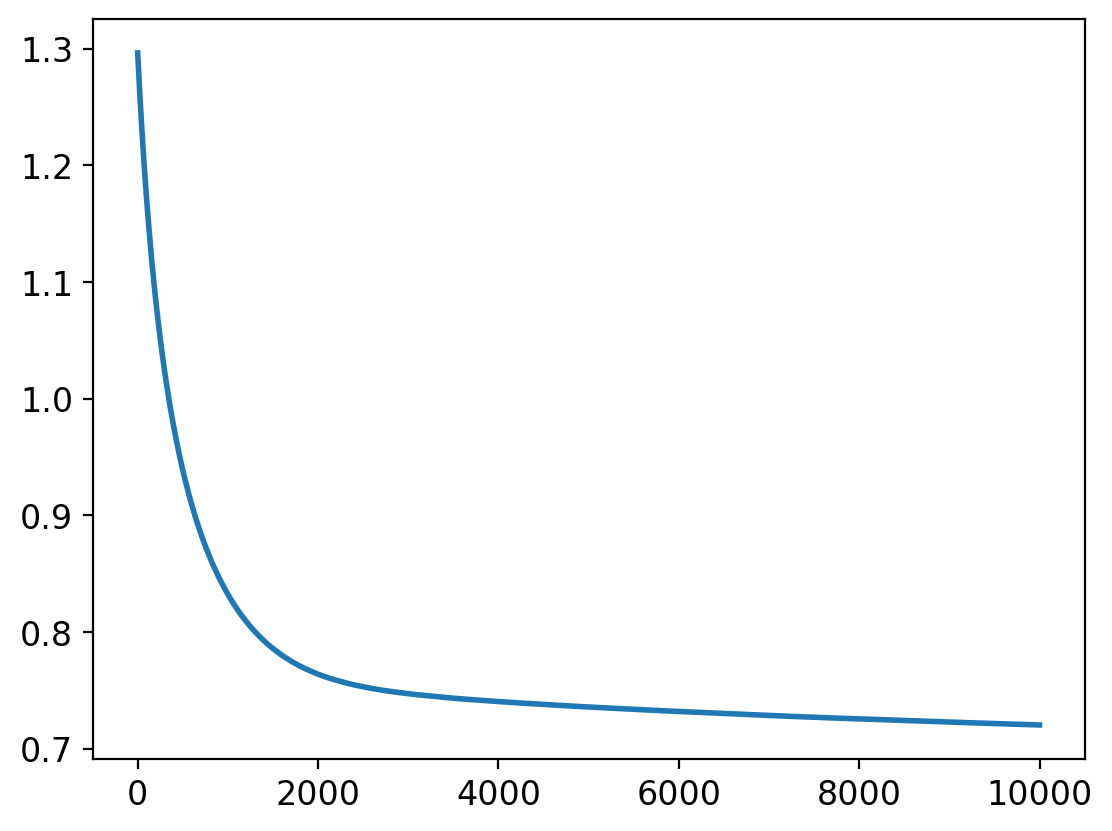

In [143]:
plt.plot(losses["test"])

In [144]:
err_test_sgd = unnorm_rmae(state_sgd.apply_fn, state_sgd.params, X_test, y_test, ymean, ystd)
err_test_sgd

Array(0.55971134, dtype=float32)

## Diag-EKF - $\text{KL}(p || q)$

In [146]:
method = "fdekf"
name_agent = "ekf-fd"
optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback, method=method,
)

In [147]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | dynami... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.018    | -0.5819   | 0.5885    | -5.145    | -1.084    |
| 2         | -0.9471   | -0.574    | 0.8274    | -1.904    | -3.698    |
| 3         | -0.9611   | -0.6177   | 0.2608    | -1.635    | -3.692    |
| 4         | -0.8034   | -6.144    | 0.386     | -1.119    | -3.609    |
| 5         | -0.8083   | -6.511    | 0.6331    | -2.907    | -2.094    |
| 6         | -0.9841   | -2.26     | 0.6872    | -3.928    | -3.395    |
| 7         | -0.8297   | -3.006    | 0.4798    | -0.9725   | -0.826    |
| 8         | -0.8086   | -6.26     | 0.06041   | -2.822    | -1.038    |
| 9         | -0.9443   | -5.416    | 0.5352    | -6.048    | -3.139    |
| 10        | -0.8046   | -5.936    | 0.4298    | -1.451    | -2.965    |
| 11        | -0.7411   | -7.0      | 1.0       | 0.0       | 0.0       |
| 12        | -0.7193   | -7.0      | 

In [148]:
%%time
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_ekf.get_best_params(n_params, optimizer, method=method)
agent = hp_ekf.build_estimator(flat_params, hparams, None, apply_fn, method=method)
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.5523
CPU times: user 1.4 s, sys: 51.6 ms, total: 1.46 s
Wall time: 1.25 s


## Diag-EKF - $\text{KL}(q || p)$

In [149]:
method = "vdekf"
name_agent = "ekf-vd"
optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback, method=method,
)

In [150]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | dynami... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.018    | -0.5819   | 0.5885    | -5.145    | -1.084    |
| 2         | -0.9542   | -0.574    | 0.8274    | -1.904    | -3.698    |
| 3         | -0.9611   | -0.6177   | 0.2608    | -1.635    | -3.692    |
| 4         | -0.8034   | -6.144    | 0.386     | -1.119    | -3.609    |
| 5         | -0.8083   | -6.511    | 0.6331    | -2.907    | -2.094    |
| 6         | -0.9841   | -2.26     | 0.6872    | -3.928    | -3.395    |
| 7         | -0.8297   | -3.006    | 0.4798    | -0.9725   | -0.826    |
| 8         | -0.8086   | -6.26     | 0.06041   | -2.822    | -1.038    |
| 9         | -0.9443   | -5.416    | 0.5352    | -6.048    | -3.139    |
| 10        | -0.8046   | -5.936    | 0.4298    | -1.451    | -2.965    |
| 11        | -0.6984   | -7.0      | 1.0       | 0.0       | 0.0       |
| 12        | -0.7062   | -7.0      | 

In [151]:
%%time
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_ekf.get_best_params(n_params, optimizer, method=method)
agent = hp_ekf.build_estimator(flat_params, hparams, None, apply_fn, method=method)
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.5516
CPU times: user 1.69 s, sys: 83.7 ms, total: 1.77 s
Wall time: 1.54 s


## LoFi - orthogonal

In [152]:
method = "orth_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    steady_state=True,
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds_lofi, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [153]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | dynami... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.007    | 0.9169    | 0.5885    | -5.145    | -1.084    |
| 2         | -0.812    | 0.918     | 0.8274    | -1.904    | -3.698    |
| 3         | -0.8247   | 0.9118    | 0.2608    | -1.635    | -3.692    |
| 4         | -0.815    | 0.1223    | 0.386     | -1.119    | -3.609    |
| 5         | -0.9473   | 0.06992   | 0.6331    | -2.907    | -2.094    |
| 6         | -0.8337   | 0.6772    | 0.6872    | -3.928    | -3.395    |
| 7         | -0.9125   | 0.5706    | 0.4798    | -0.9725   | -0.826    |
| 8         | -0.9888   | 0.1058    | 0.06041   | -2.822    | -1.038    |
| 9         | -1.007    | 0.2264    | 0.5352    | -6.048    | -3.139    |
| 10        | -0.8323   | 0.152     | 0.4298    | -1.451    | -2.965    |
| 11        | -0.7089   | 1e-05     | 1.0       | -3.098    | -5.0      |
| 12        | -0.8444   | 1.0       | 

In [154]:
%%time
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

name_agent = "lofi-orth"
hparams = hp_lofi.get_best_params(n_params, optimizer)
agent = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.5560
CPU times: user 2.12 s, sys: 98.1 ms, total: 2.21 s
Wall time: 1.69 s


## LoFi - full svd
With steady-state assumption

In [155]:
method = "full_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    steady_state=True,
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds_lofi, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [156]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | dynami... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.014    | 0.9169    | 0.5885    | -5.145    | -1.084    |
| 2         | -0.8068   | 0.918     | 0.8274    | -1.904    | -3.698    |
| 3         | -0.8253   | 0.9118    | 0.2608    | -1.635    | -3.692    |
| 4         | -0.8172   | 0.1223    | 0.386     | -1.119    | -3.609    |
| 5         | -0.9298   | 0.06992   | 0.6331    | -2.907    | -2.094    |
| 6         | -0.9113   | 0.6772    | 0.6872    | -3.928    | -3.395    |
| 7         | -0.9063   | 0.5706    | 0.4798    | -0.9725   | -0.826    |
| 8         | -0.9887   | 0.1058    | 0.06041   | -2.822    | -1.038    |
| 9         | -1.004    | 0.2264    | 0.5352    | -6.048    | -3.139    |
| 10        | -0.8372   | 0.152     | 0.4298    | -1.451    | -2.965    |
| 11        | -0.6836   | 1.0       | 1.0       | 0.0       | -5.0      |
| 12        | -0.6677   | 1.0       | 

In [157]:
%%time
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

name_agent = "lofi-full"
hparams = hp_lofi.get_best_params(n_params, optimizer)
agent = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=True, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

  0%|          | 0/4198 [00:00<?, ?it/s]

0.5393
CPU times: user 4.13 s, sys: 207 ms, total: 4.34 s
Wall time: 3.79 s


## LoFi generalised

In [158]:
method = "generalized_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds_lofi, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [159]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | dynami... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.019    | 0.9169    | 0.5885    | -5.145    | -1.084    |
| 2         | -0.9876   | 0.918     | 0.8274    | -1.904    | -3.698    |
| 3         | -0.9808   | 0.9118    | 0.2608    | -1.635    | -3.692    |
| 4         | -0.8629   | 0.1223    | 0.386     | -1.119    | -3.609    |
| 5         | -0.9272   | 0.06992   | 0.6331    | -2.907    | -2.094    |
| 6         | -1.014    | 0.6772    | 0.6872    | -3.928    | -3.395    |
| 7         | -0.9332   | 0.5706    | 0.4798    | -0.9725   | -0.826    |
| 8         | -0.9413   | 0.1058    | 0.06041   | -2.822    | -1.038    |
| 9         | -1.018    | 0.2264    | 0.5352    | -6.048    | -3.139    |
| 10        | -0.8893   | 0.152     | 0.4298    | -1.451    | -2.965    |
| 11        | -0.8019   | 1e-05     | 0.4742    | -0.283    | -3.225    |
| 12        | -0.6684   | 1e-05     | 

In [160]:
%%time
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

name_agent = "lofi-generalized"
hparams = hp_lofi.get_best_params(n_params, optimizer)
agent = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=True, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

  0%|          | 0/4198 [00:00<?, ?it/s]

0.5508
CPU times: user 10 s, sys: 766 ms, total: 10.8 s
Wall time: 9.9 s


## ORFit

In [161]:
%%time
method = "orfit"
params_orfit = base.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    **hparams
)


name_agent = "orfit"
agent = lofi.RebayesLoFi(params_orfit, params_lofi, method=method)
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=True, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

  0%|          | 0/4198 [00:00<?, ?it/s]

0.6667
CPU times: user 1.69 s, sys: 29.9 ms, total: 1.72 s
Wall time: 1.24 s


## FC-EKF

In [162]:
optimizer, apply_fn, n_features = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback, method="fcekf"
)

In [163]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | dynami... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.018    | -0.5819   | 0.5885    | -5.145    | -1.084    |
| 2         | -0.9685   | -0.574    | 0.8274    | -1.904    | -3.698    |
| 3         | -0.9611   | -0.6177   | 0.2608    | -1.635    | -3.692    |
| 4         | -0.8034   | -6.144    | 0.386     | -1.119    | -3.609    |
| 5         | -0.8083   | -6.511    | 0.6331    | -2.907    | -2.094    |
| 6         | -0.9841   | -2.26     | 0.6872    | -3.928    | -3.395    |
| 7         | -0.8297   | -3.006    | 0.4798    | -0.9725   | -0.826    |
| 8         | -0.8086   | -6.26     | 0.06041   | -2.822    | -1.038    |
| 9         | -0.9443   | -5.416    | 0.5352    | -6.048    | -3.139    |
| 10        | -0.8046   | -5.936    | 0.4298    | -1.451    | -2.965    |
| 11        | -0.8305   | -7.0      | 1.0       | 0.0       | 0.0       |
| 12        | -0.8021   | -7.0      | 

In [164]:
%%time
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

name_agent = "ekf-fc"
hparams = hp_ekf.get_best_params(n_params, optimizer, method="fcekf")
agent = hp_ekf.build_estimator(flat_params, hparams, None, apply_fn, method="fcekf")
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=True, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

  0%|          | 0/4198 [00:00<?, ?it/s]

0.5403
CPU times: user 1.73 s, sys: 35 ms, total: 1.77 s
Wall time: 1.53 s


## L-RVGA

In [165]:
def fwd_link(mean, bel, x):
    params = reconstruct_fn(mean)
    means = model.apply(params, x).ravel()
    std = bel.sigma
    return means, std ** 2

def log_prob(mean, bel, x, y):
    yhat, std = fwd_link(mean, bel, x)
    std = jnp.sqrt(std)
    
    logp = distrax.Normal(yhat, std).log_prob(y).sum()
    return logp

In [166]:
def bbf(std, sigma2, eps, train, test, n_inner, n_outer):
    X_train, y_train = train
    X_test, y_test = test
    
    std = np.exp(std)
    sigma2 = np.exp(sigma2)
    eps = np.exp(eps)
        
    hparams = {
        "std": std,
        "sigma2": sigma2,
        "eps": eps,
    }
    
    bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, X_train, dim_rank, **hparams)
    agent = lrvga.LRVGA(fwd_link, log_prob, n_samples=30, n_outer=n_outer, n_inner=n_inner)
    bel, _ = agent.scan(X_train, y_train, progress_bar=False, bel=bel_init)
    
    metric = jnp.abs(agent.predict_obs(bel, X_test) - y_test).mean()
    isna = np.isnan(metric)
    metric = 1000 if isna else metric
    return -metric

In [167]:
dim_rank = 50
n_outer = 6
n_inner = 4
_, reconstruct_fn = ravel_pytree(model.init(key, X_learn))

In [168]:
%%time
# In log-space
lrvga_bounds = {
    "std": (-0.34, 0.0),
    "sigma2": (-4, 0.0),
    "eps": (-10, -4),
}

from bayes_opt import BayesianOptimization
pbbf = partial(bbf, train=warmup_train, test=warmup_test, n_outer=n_outer, n_inner=n_inner)

optimizer = BayesianOptimization(
    f=pbbf,
    pbounds=lrvga_bounds,
    random_state=314,
)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   |    eps    |  sigma2   |    std    |
-------------------------------------------------------------
| 1         | -1e+03    | -4.499    | -1.646    | -0.2499   |
| 2         | -1e+03    | -5.301    | -0.328    | -0.0587   |
| 3         | -0.6626   | -5.632    | -2.958    | -0.03     |
| 4         | -1e+03    | -8.435    | -0.9345   | -0.2511   |
| 5         | -0.667    | -9.266    | -2.456    | -0.05437  |
| 6         | -0.6683   | -8.331    | -3.72     | -0.1247   |
| 7         | -0.6726   | -6.491    | -1.675    | -0.1098   |
| 8         | -0.6828   | -5.877    | -2.244    | -0.2309   |
| 9         | -0.6681   | -6.577    | -2.081    | -0.04723  |
| 10        | -0.692    | -4.991    | -3.577    | -0.3195   |
| 11        | -0.6694   | -10.0     | -3.937    | 0.0       |
| 12        | -0.6999   | -6.538    | -4.0      | -0.34     |
| 13        | -0.6681   | -4.0      | -4.0      | 0.0       |
| 14        | -0.7077   | -9.985    | -2.921    | -0.3139   |
| 15    

In [169]:
jax.tree_map(jnp.exp, optimizer.max["params"])

{'eps': Array(0.00358036, dtype=float32),
 'sigma2': Array(0.05191858, dtype=float32),
 'std': Array(0.97044337, dtype=float32)}

In [170]:
%%time
hparams_lrvga = jax.tree_map(np.exp, optimizer.max["params"])
bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, X_learn, dim_rank, **hparams_lrvga)

name_agent = f"l-rvga"
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}
agent = lrvga.LRVGA(fwd_link, log_prob, n_samples=30, n_outer=n_outer, n_inner=n_inner)
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=True, bel=bel_init, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

  0%|          | 0/4198 [00:00<?, ?it/s]

0.5384
CPU times: user 20.7 s, sys: 1.62 s, total: 22.3 s
Wall time: 1min 12s


## Plot results

In [171]:
colors = plt.cm.tab10(np.linspace(0, 1, len(agents)))
colors = plt.cm.tab10(np.arange(len(agents)))
colors = {
    name_agent: color
    for name_agent, color
    in zip(agents, colors)
}

In [172]:
data = get_subtree(agents_output, "test")
data = tree_to_cpu(data)
data = pd.DataFrame(data)
data.tail()

,ekf-fc,ekf-fd,ekf-vd,l-rvga,lofi-full,lofi-generalized,lofi-orth,orfit
4193,0.540269,0.552952,0.552227,0.538500,0.539313,0.551642,0.556664,0.771932
4194,0.540300,0.552925,0.552061,0.538506,0.539374,0.551682,0.556271,0.809684
4195,0.540283,0.552828,0.551916,0.538428,0.539285,0.549910,0.556113,0.640274
4196,0.540267,0.552312,0.551470,0.538282,0.539276,0.548913,0.555463,0.642785
4197,0.540277,0.552303,0.551620,0.538391,0.539273,0.550772,0.555952,0.666742


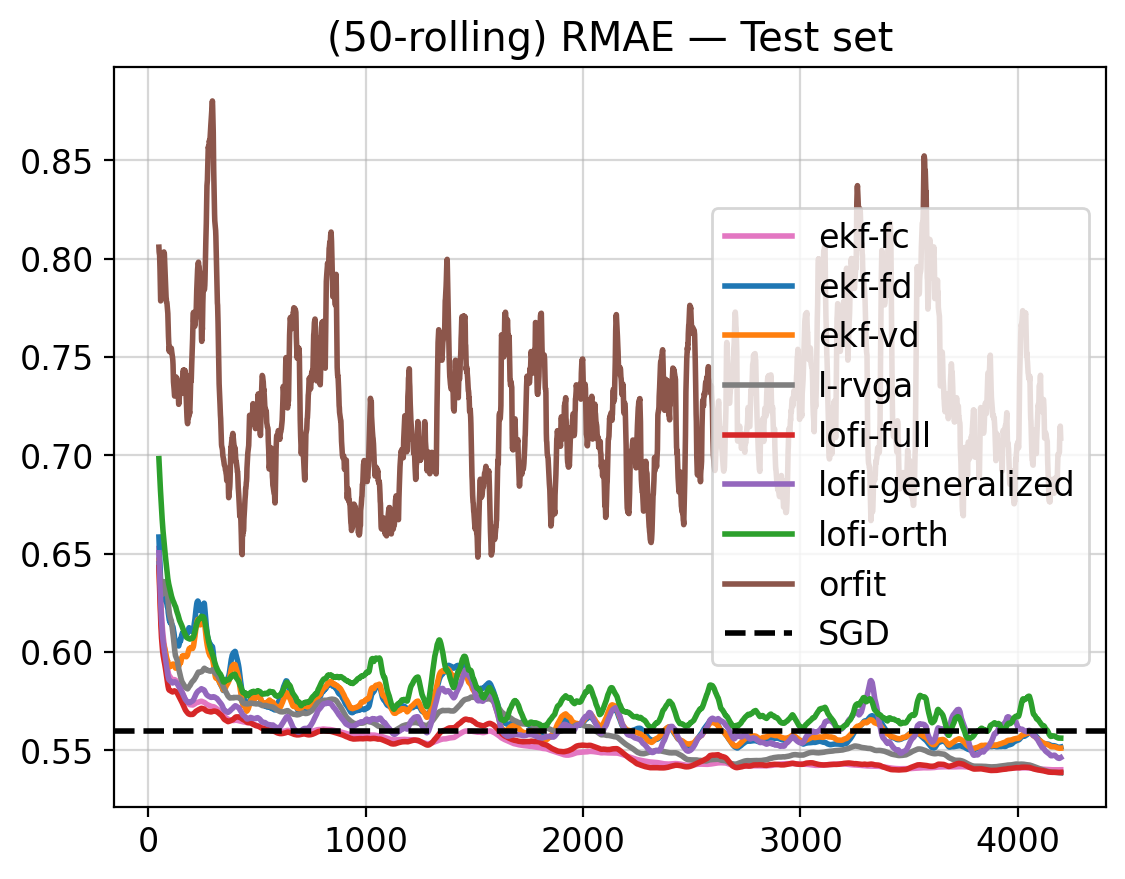

In [173]:
fig, ax = plt.subplots()
size_window = 50
data.drop([], axis=1).rolling(size_window).mean().plot(color=colors, ax=ax)
dmean = data.tail().mean().mean()
dstd = data.tail().mean().std()
# plt.ylim(dmean - dstd * 0.8, dmean + 2 * dstd)
plt.axhline(y=err_test_sgd, c="black", linestyle="--", label="SGD")
plt.legend()
plt.title(f"({size_window}-rolling) RMAE — Test set")
plt.grid(alpha=0.5)

# Simulations

In [174]:
def eval_runs(key, num_runs_pc, agent):
    num_devices = jax.device_count()
    num_sims = num_runs_pc * num_devices
    keys = jax.random.split(key, num_sims).reshape(-1, num_devices, 2)
    n_vals = len(X_learn)
    
    @partial(jax.pmap, in_axes=1)
    @partial(jax.vmap, in_axes=0)
    def evalf(key):
        key_shuffle, key_init = jax.random.split(key)
        ixs_shuffle = jax.random.choice(key, n_vals, (n_vals,), replace=False)
        
        params = model.init(key, jnp.ones((1, dim_in)))
        flat_params, _ = ravel_pytree(params)
        
        n_params = len(flat_params)

        bel, output = agent.scan(
            X_learn[ixs_shuffle], y_learn[ixs_shuffle], callback=eval_callback, progress_bar=False, **test_kwargs
        )
        return output
    
    
    outputs = evalf(keys)
    outputs = jax.tree_map(lambda x: x.reshape(num_sims, -1), outputs)
    return outputs

In [175]:
def eval_runs_lrvga(key, num_runs_pc, agent, hparams):
    num_devices = jax.device_count()
    num_sims = num_runs_pc * num_devices
    keys = jax.random.split(key, num_sims).reshape(-1, num_devices, 2)
    n_vals = len(X_learn)
    
    @partial(jax.pmap, in_axes=1)
    @partial(jax.vmap, in_axes=0)
    def evalf(key):
        key_shuffle, key_init = jax.random.split(key)
        bel_init, reconstruct_fn = lrvga.init_lrvga(key_init, model, X_learn, dim_rank, **hparams)        
        ixs_shuffle = jax.random.choice(key_shuffle, n_vals, (n_vals,), replace=False)
        
        
        bel, output = agent.scan(
            X_learn[ixs_shuffle], y_learn[ixs_shuffle], callback=eval_callback, progress_bar=False, bel=bel_init, **test_kwargs
        )
        return output
    
    
    outputs = evalf(keys)
    outputs = jax.tree_map(lambda x: x.reshape(num_sims, -1), outputs)
    return outputs

In [176]:
def plot_sims(data, ax, color, label, rolling=100):
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    sims = data.rolling(rolling).mean().values
    plt.plot(sims, c=color, alpha=0.07, linewidth=1)

In [177]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 1 * std_sim
    ubound = mean_sim + 1 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)

## Run simulations

In [178]:
sims = {}

In [179]:
%%time
n_agents = len(agents)
for name, agent in tqdm(agents.items(), total=n_agents):
    if name == "l-rvga":
        continue
    res = eval_runs(key, num_runs_pc=5, agent=agent)
    sims[name] = jax.tree_map(np.array, res)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 1min 46s, sys: 4.92 s, total: 1min 51s
Wall time: 1min 46s


In [180]:
%%time
name = "l-rvga"
res = eval_runs_lrvga(key, num_runs_pc=5, agent=agents[name], hparams=hparams_lrvga)
sims[name] = jax.tree_map(np.array, res)

CPU times: user 53 s, sys: 4.02 s, total: 57 s
Wall time: 5min 23s


In [181]:
jax.tree_map(jnp.shape, sims)

{'ekf-fc': {'osa-error': (40, 4198), 'test': (40, 4198)},
 'ekf-fd': {'osa-error': (40, 4198), 'test': (40, 4198)},
 'ekf-vd': {'osa-error': (40, 4198), 'test': (40, 4198)},
 'l-rvga': {'osa-error': (40, 4198), 'test': (40, 4198)},
 'lofi-full': {'osa-error': (40, 4198), 'test': (40, 4198)},
 'lofi-generalized': {'osa-error': (40, 4198), 'test': (40, 4198)},
 'lofi-orth': {'osa-error': (40, 4198), 'test': (40, 4198)},
 'orfit': {'osa-error': (40, 4198), 'test': (40, 4198)}}

## Plots

### Plot rolling RMAE on the test set

In [182]:
collection = get_subtree(sims, "test")

In [183]:
void_methods = ["orfit", "lofi-generalized"]
void_methods = []

In [184]:
collection = {
    agent: pd.DataFrame(res["test"]).T.dropna(axis=1)
    for agent, res in sims.items()
    if agent not in void_methods
}

In [185]:
dv = jax.tree_util.tree_flatten(jax.tree_map(lambda x: np.nanmean(x[-10:]), collection))[0]
dmean = np.mean(dv)
dstd = np.mean(dstd)

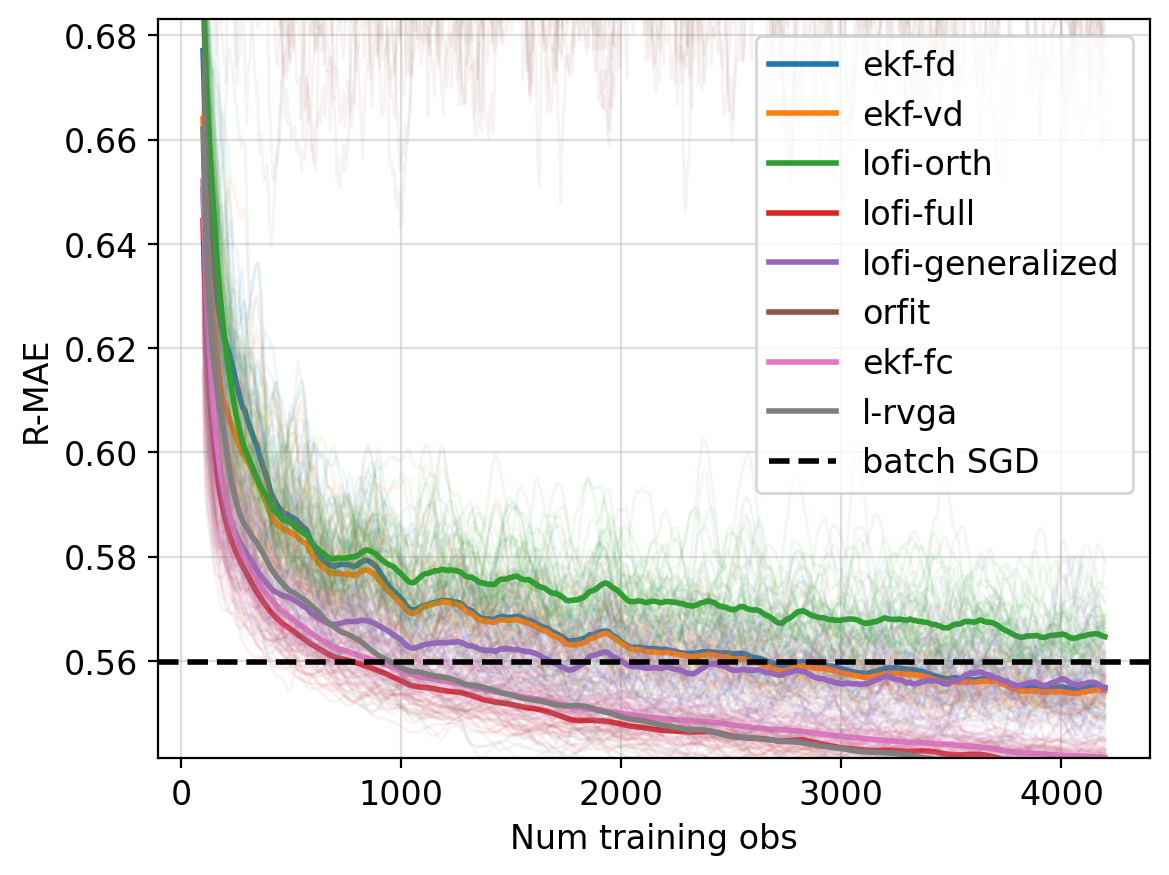

In [186]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label)

plt.axhline(y=err_test_sgd, c="black", linestyle="--", label="batch SGD")
plt.legend()
plt.grid(alpha=0.4)
plt.ylim(dmean - 0.5 * dstd, dmean + 2 * dstd)

plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/sims-{dataset}.pdf")

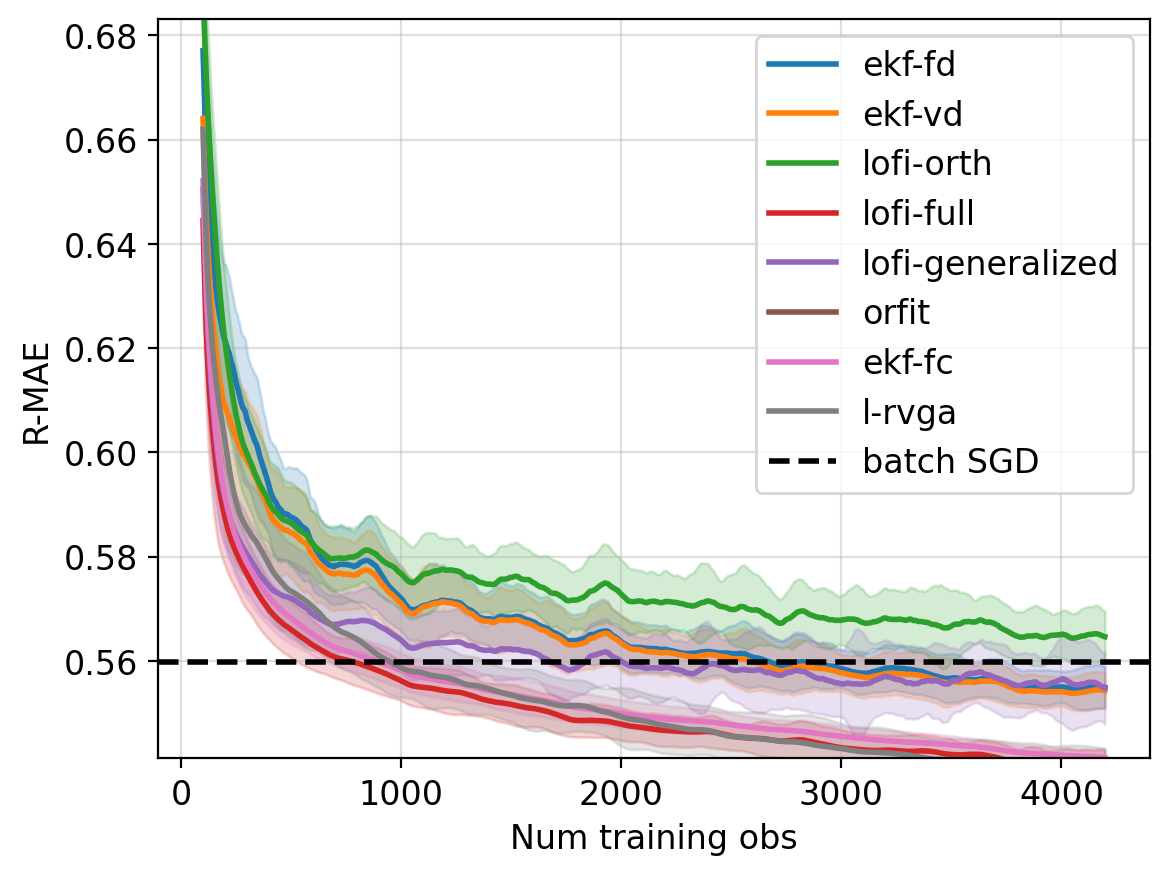

In [187]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label)

plt.axhline(y=err_test_sgd, c="black", linestyle="--", label="batch SGD")
plt.legend()
plt.grid(alpha=0.4)
plt.ylim(dmean - 0.5 * dstd, dmean + 2 * dstd)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/bounds-{dataset}.pdf")

In [188]:
last_rmae = {
    key: collection[key].iloc[-1]
    for key in collection
}
last_rmae = pd.DataFrame(last_rmae)

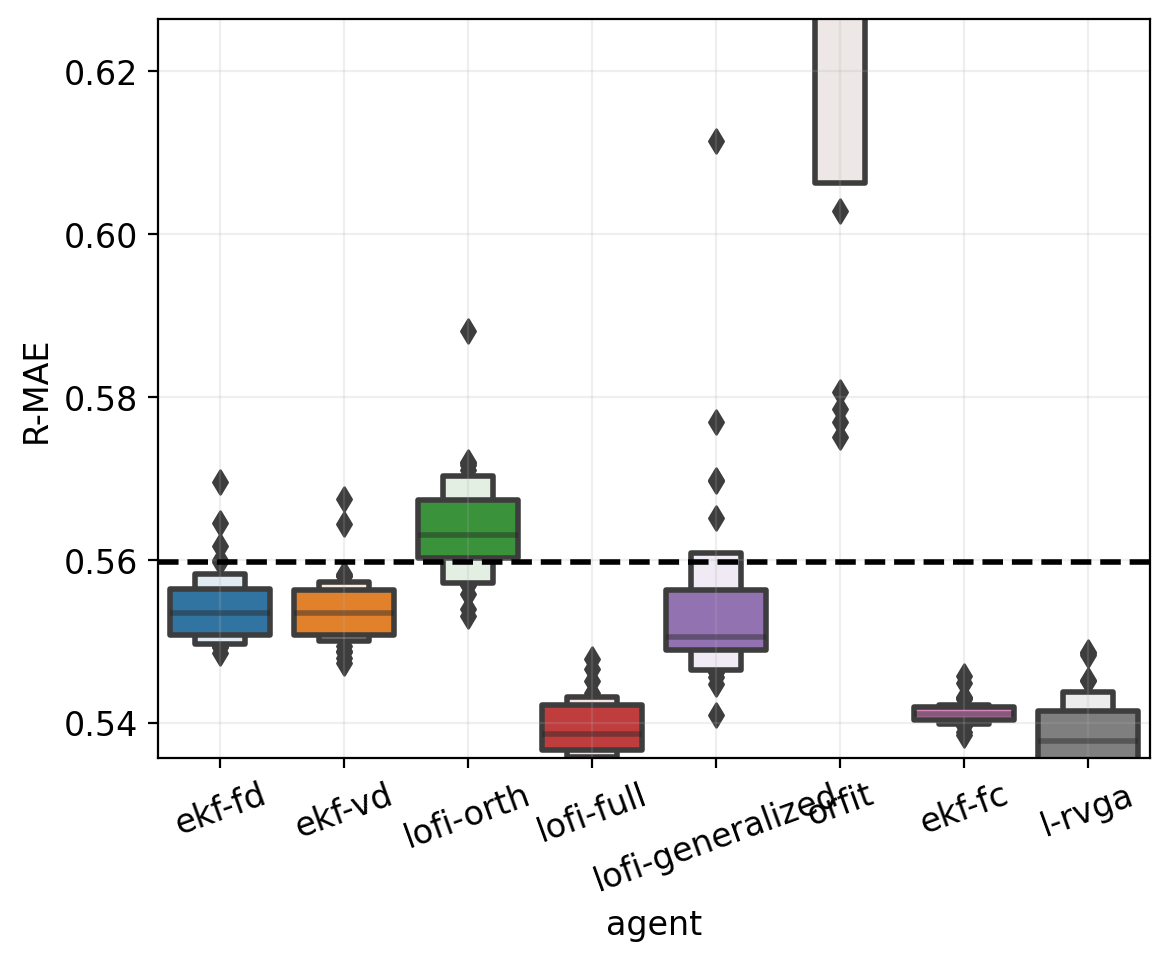

In [189]:
sns.boxenplot(
    x="agent",
    y="R-MAE",
    palette=colors,
    data=last_rmae.melt(var_name="agent", value_name="R-MAE")
)
plt.axhline(y=err_test_sgd, c="black", linestyle="--", label="batch SGD")
plt.grid(alpha=0.2)
plt.xticks(rotation=20)
plt.ylim(dmean - 0.6 * dstd, dmean + 1 * dstd)

plt.savefig(f"output/last-metric-{dataset}.pdf")

### Plot rolling RMAE on the one-step-ahead posterior predictive

In [190]:
collection = {
    agent: pd.DataFrame(res["osa-error"]).T.dropna(axis=1)
    for agent, res in sims.items()
}

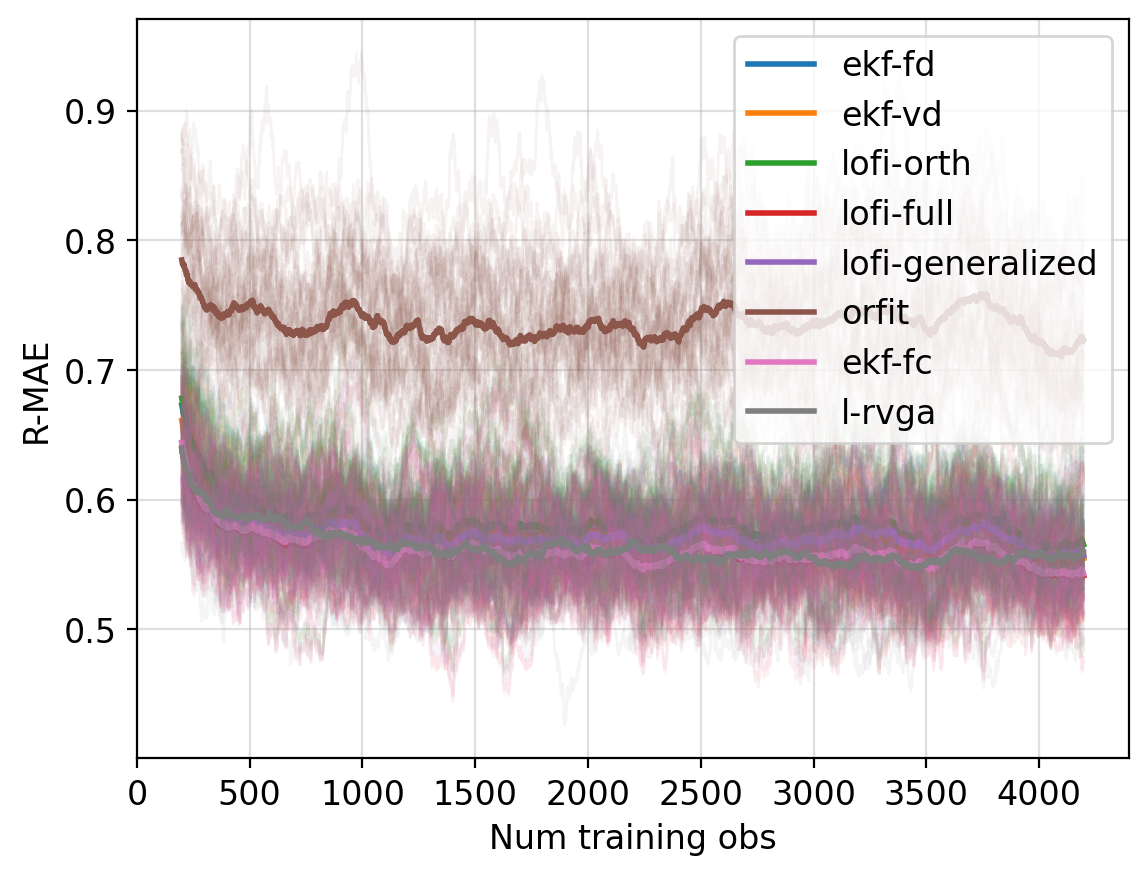

In [191]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-sims-{dataset}.pdf")

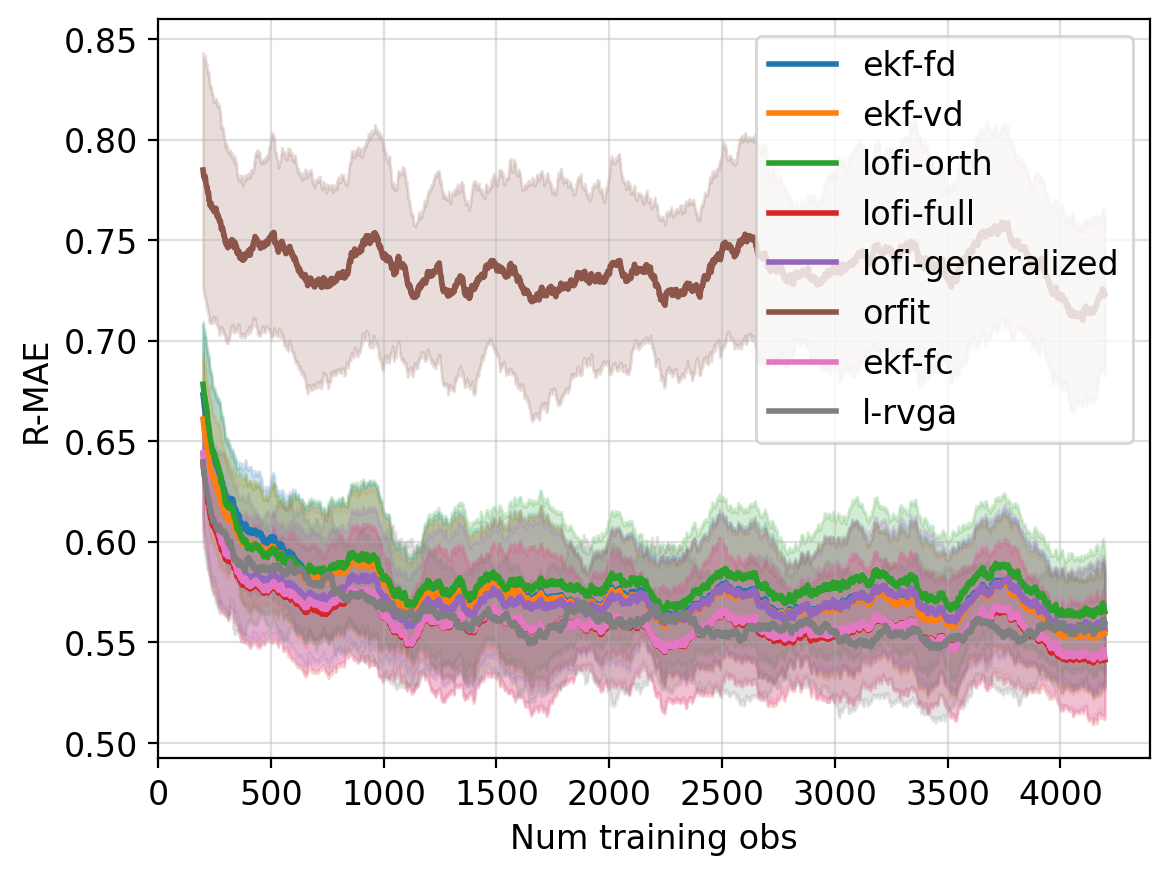

In [192]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-bounds-{dataset}.pdf")